## Part 1: Loading data, summary statistics, and plotting/correlations

In [1]:
# 1.
from datetime import datetime as dt
import pandas as pd
from numpy import argmax
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


charging_station_data = pd.read_csv('data/charging_station_data.tsv', sep='\t', encoding='ISO-8859-1')

charging_cols = [
	# unique identifiers
	'id',
	'station_name',

	# associate using date
	'open_date',

	# associate using location
	# 'country',
	'state',
	# 'city',

	# filter using status
	'status_code',
]
print(charging_station_data.head(10))

policy_data = pd.read_csv('data/transportation_policy_data.tsv', sep='\t', encoding='ISO-8859-1')
print(policy_data.head(10))

policy_cols = [
	# unique identifiers
	'id',
	'title',

	# associate using date
	'significant_update_date',

	# associate using location
	'state',

	# categorization
	'type',
	'categories'
]

parsed_date_col = 'parsed_date'

                        station_name   open_date    id date_last_confirmed  \
0           LADWP - Truesdale Center  1999-10-15  1517          2023-09-14   
1    LADWP - West LA District Office  2020-02-28  1519          2023-01-10   
2      Los Angeles Convention Center  1995-08-30  1523          2023-01-10   
3      LADWP - John Ferraro Building  1999-10-15  1525          2023-09-14   
4         LADWP - Haynes Power Plant  2018-05-01  1531          2023-01-10   
5  LADWP - Harbor Generating Station  1999-10-15  1552          2023-01-10   
6                LADWP - Sylmar West  2016-01-01  1556          2023-01-10   
7          LADWP - EV Service Center  1999-10-15  1572          2023-01-10   
8             LADWP - Fairfax Center  2019-04-01  1573          2023-01-10   
9     California Air Resources Board  1996-10-15  1583          2022-09-14   

  expected_date status_code            updated_at   facility_type  \
0           NaN           E  2023-09-14T14:01:49Z         UTILITY   
1  

In [2]:
def null_filtered(data, cols):
    mask = 1
    for col in cols:
        mask &= data[col].notnull()
    return data[mask].reset_index()

def get_formatted_date(data_slice, date_col, format: str):
    return [
        dt.strptime(date_str, format)
        for date_str in data_slice[date_col]
    ]

charging_station_data = null_filtered(charging_station_data, charging_cols)[charging_cols]
charging_station_data[parsed_date_col] = get_formatted_date(
    charging_station_data,
    'open_date',
    '%Y-%m-%d'
)
policy_data = null_filtered(policy_data, policy_cols)[policy_cols]
policy_data[parsed_date_col] = get_formatted_date(
    policy_data,
    'significant_update_date',
    '%m/%d/%Y'
)

In [3]:
# run summary statistics on charging station data
charging_station_data.info()
charging_station_data.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78395 entries, 0 to 78394
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            78395 non-null  object        
 1   station_name  78395 non-null  object        
 2   open_date     78395 non-null  object        
 3   state         78395 non-null  object        
 4   status_code   78395 non-null  object        
 5   parsed_date   78395 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 3.6+ MB


,id,station_name,open_date,state,status_code,parsed_date
0,1517,LADWP - Truesdale Center,1999-10-15,CA,E,1999-10-15


In [4]:
policy_data.info()
policy_data.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       1121 non-null   int64         
 1   title                    1121 non-null   object        
 2   significant_update_date  1121 non-null   object        
 3   state                    1121 non-null   object        
 4   type                     1121 non-null   object        
 5   categories               1121 non-null   object        
 6   parsed_date              1121 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 61.4+ KB


,id,title,significant_update_date,state,type,categories,parsed_date
0,284,Congestion Mitigation and Air Quality (CMAQ) I...,11/29/2021,US,Incentives,"[{'code': 'STATION', 'title': 'Alternative Fue...",2021-11-29


In [5]:
# helpers for plotting
def get_name(unformatted):
	return unformatted

def make_scatterplot(slice, x_col, y_col, title):
	sns.scatterplot(data=slice, x=x_col, y=y_col)
	plt.title(title)
	plt.xlabel(get_name(x_col))
	plt.ylabel(get_name(y_col))
	plt.show()

def make_boxplot(slice, x_col, y_col, title):
	sns.boxplot(data=slice, x=x_col, y=y_col)
	plt.title(title)
	plt.xlabel(get_name(x_col))
	plt.ylabel(get_name(y_col))
	plt.show()

def make_vertical_boxplot(slice, col, title):
	_, ax = plt.subplots(figsize=(6, 3), sharey=True, sharex=True)
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
	ax.spines['left'].set_visible(False)
	ax.set_title(title)
	ax.boxplot(slice[col])

def make_barplot(slice, x_col, y_col, x_label, y_label, title):
	sns.barplot(data=slice, x=x_col, y=y_col, hue=x_col)
	plt.title(title)
	plt.xlabel(x_label)
	plt.ylabel(y_label)
	plt.xticks(rotation=30)
	plt.show()

def filter_by_state(data_slice, state):
	return data_slice[data_slice['state'] == state].reset_index()

def filter_outliers(data_slice, col, limit):
	return data_slice[data_slice[col] < limit]

def group_by_date(data_slice, date_col):
	grouped_slice = data_slice.groupby(data_slice[date_col].dt.year).count()
	grouped_slice = grouped_slice.drop(columns=date_col)
	return grouped_slice

In [6]:
# stations built per year by state

stations_per_year_by_state = {}
for state in set(charging_station_data['state']):
	state_data = filter_by_state(
		charging_station_data,
		state
	)
	state_data = group_by_date(state_data, parsed_date_col)
	make_barplot(
		state_data,
		parsed_date_col,
		'id',
		'Year',
		'Charging Stations built',
		f'{state} Stations'
	)
	stations_per_year_by_state[state] = state_data

ValueError: Could not interpret value `island` for `hue`. An entry with this name does not appear in `data`.

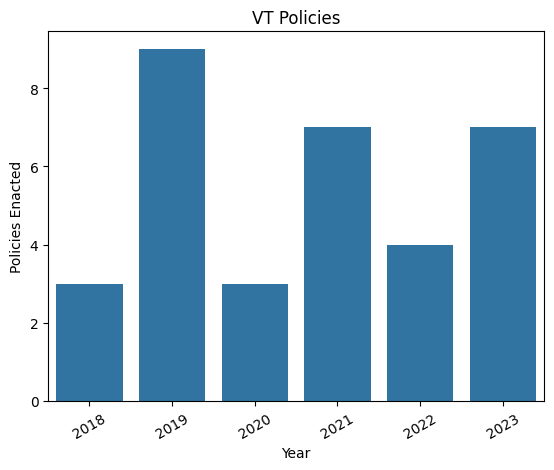

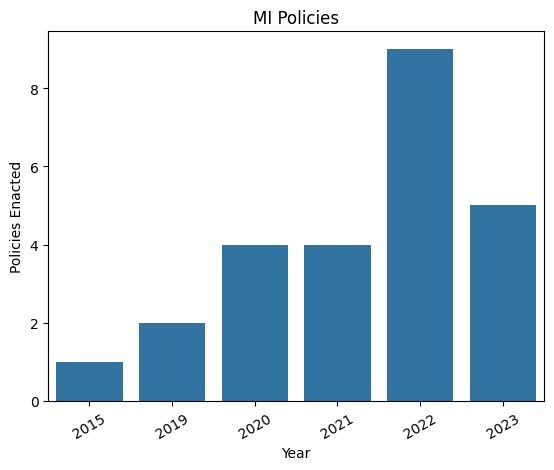

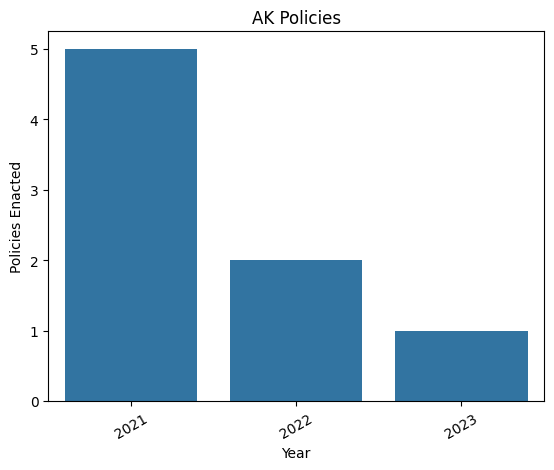

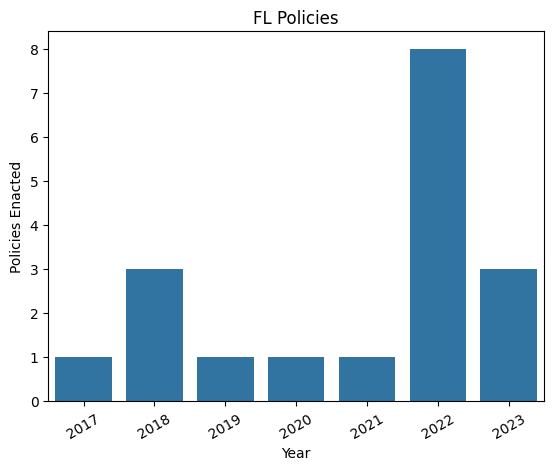

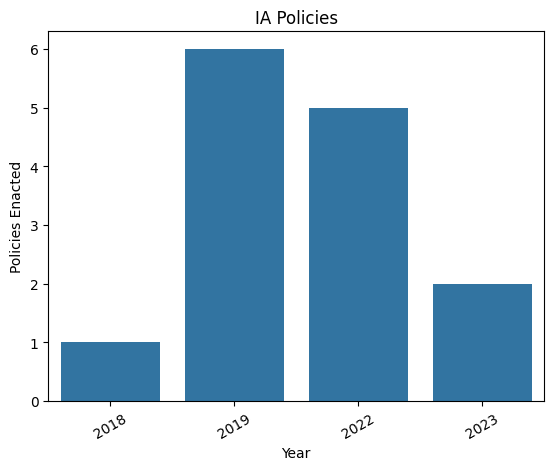

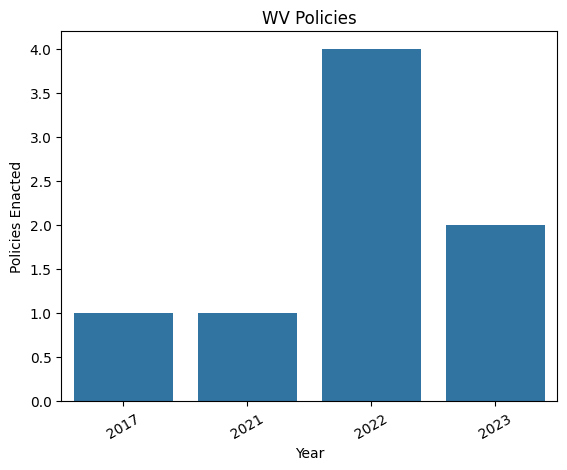

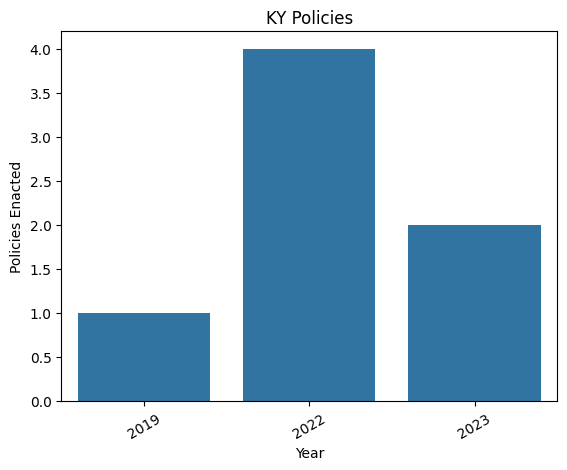

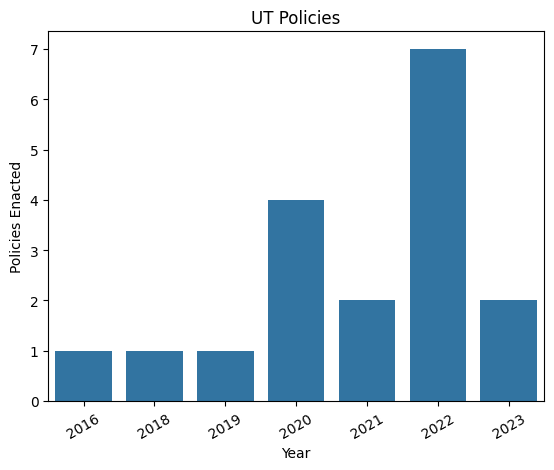

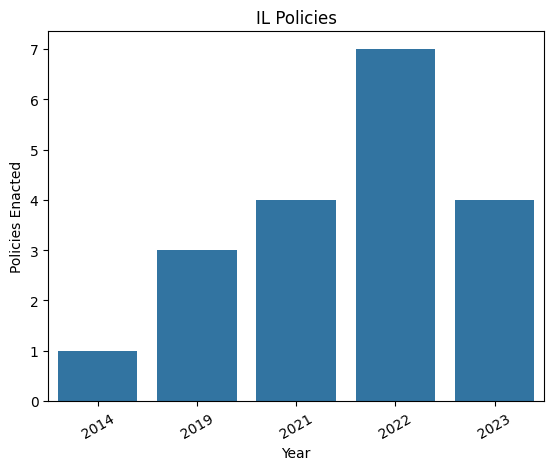

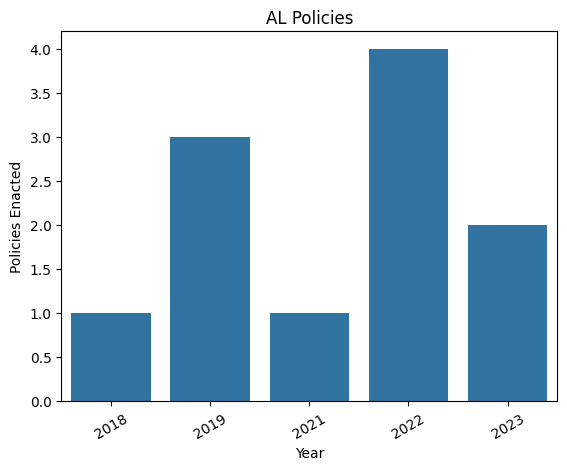

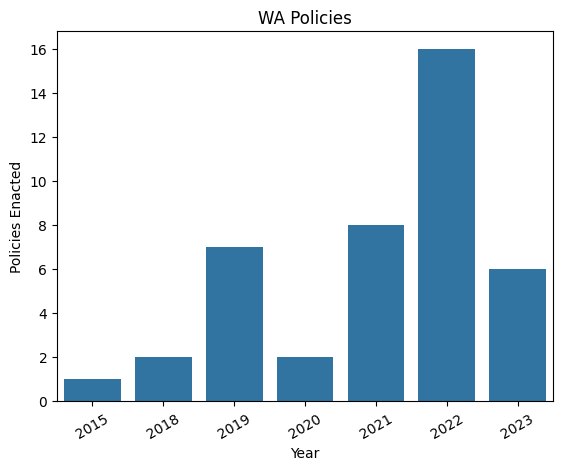

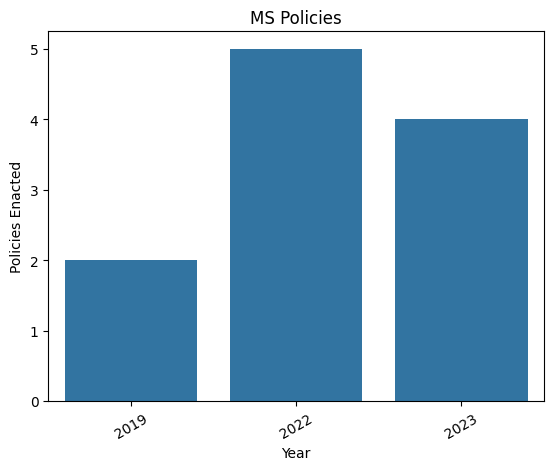

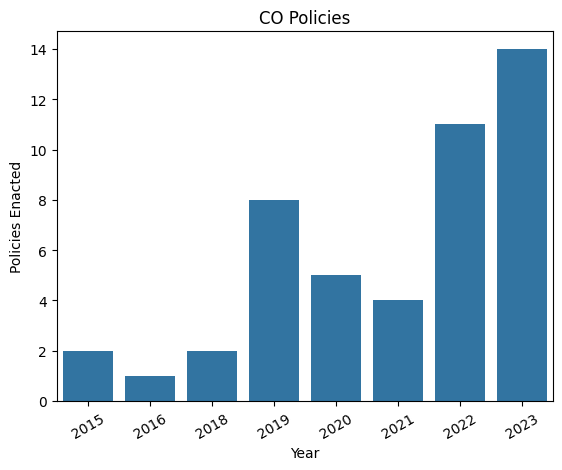

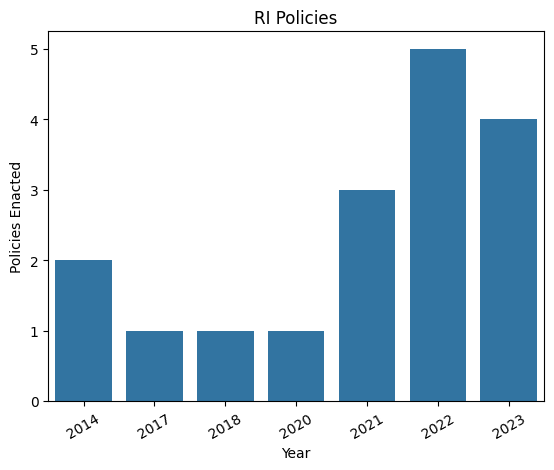

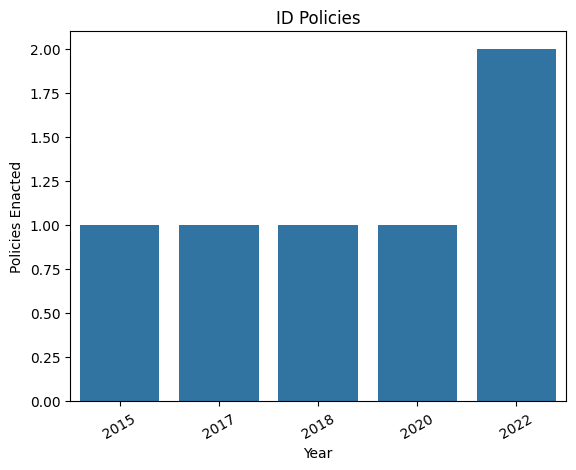

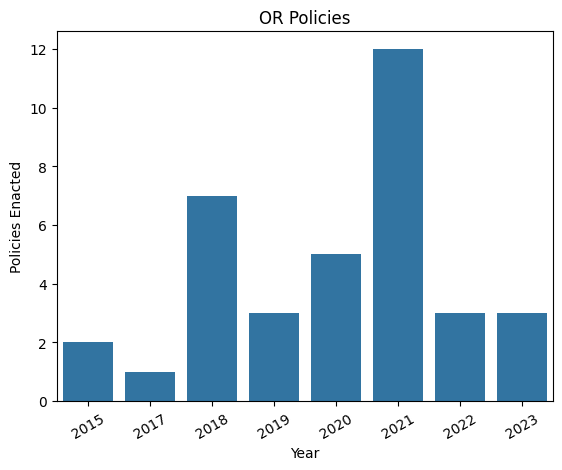

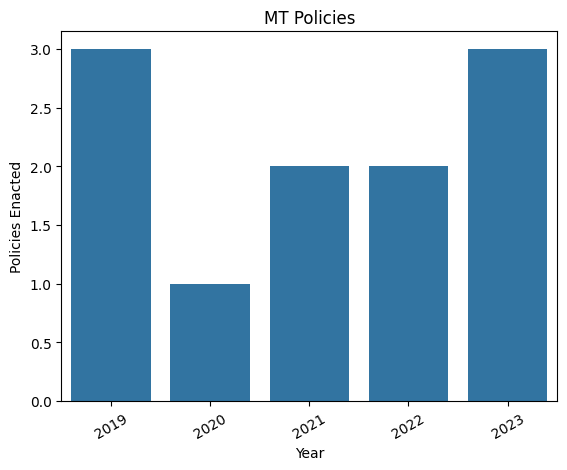

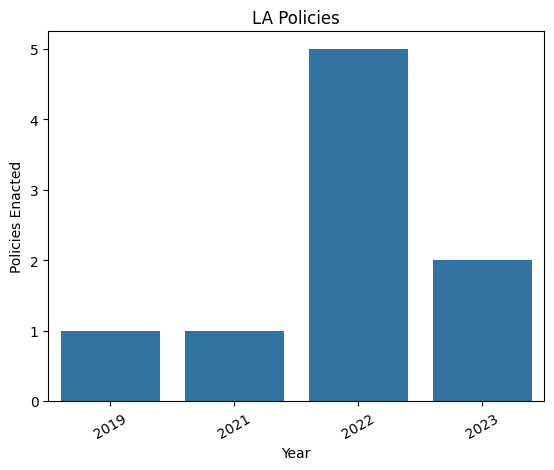

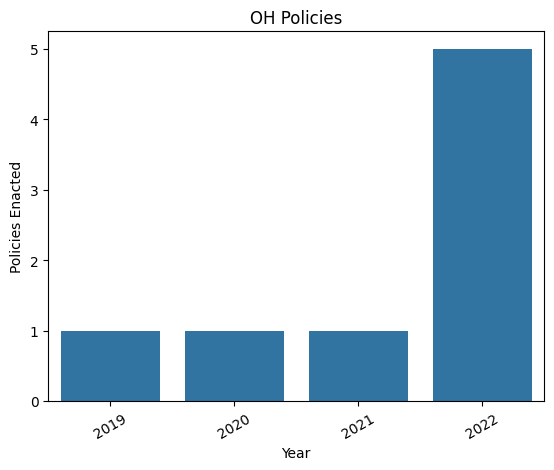

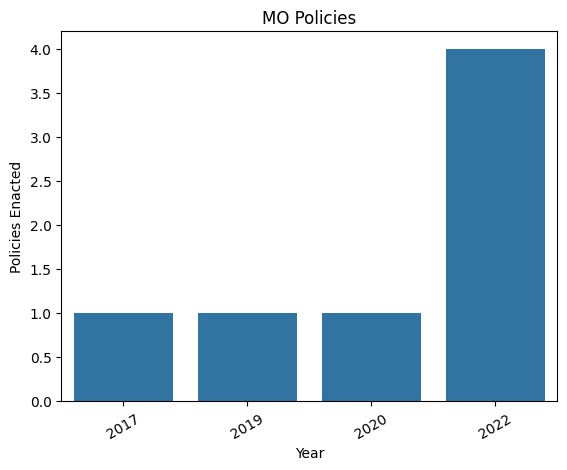

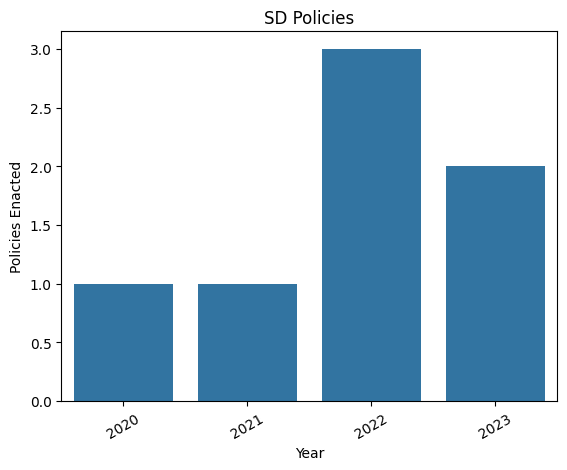

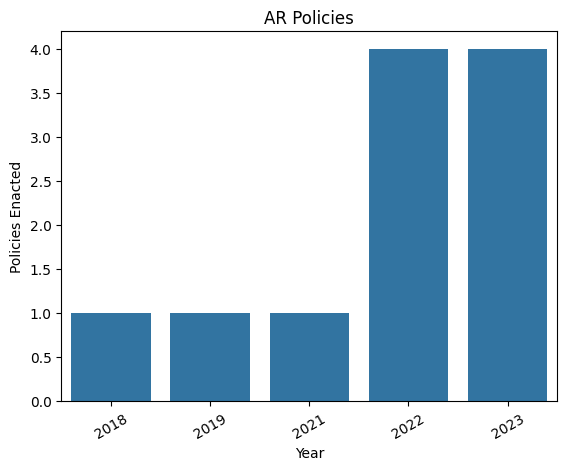

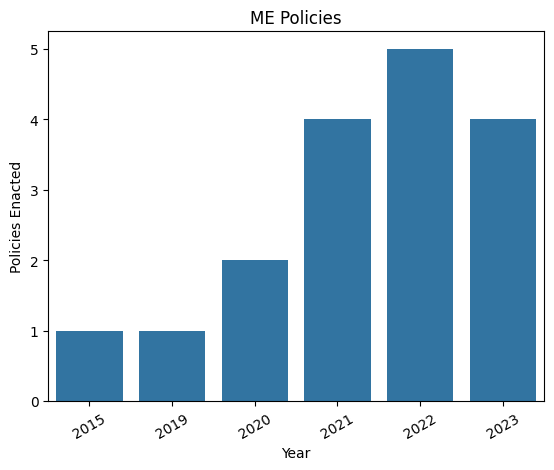

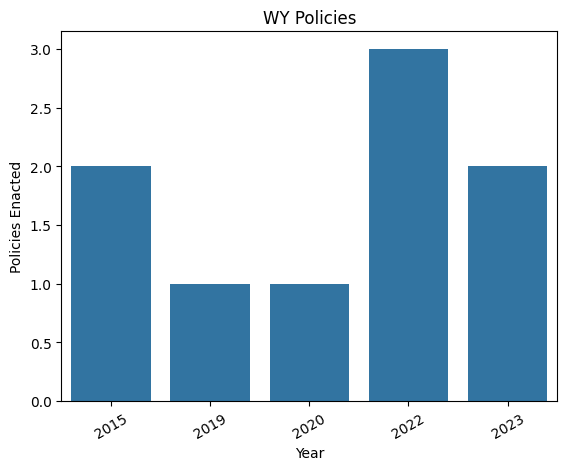

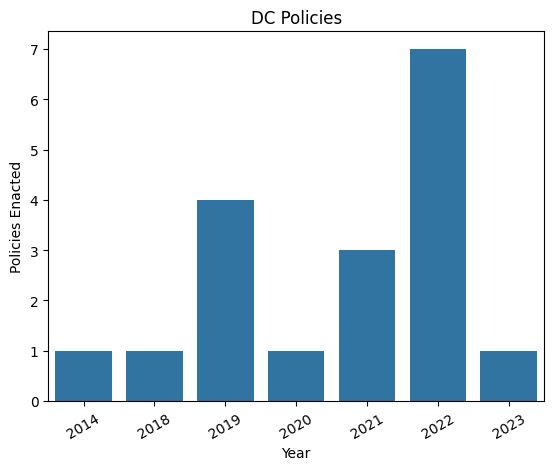

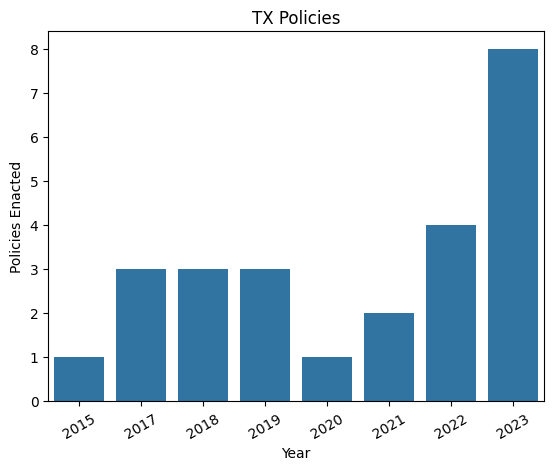

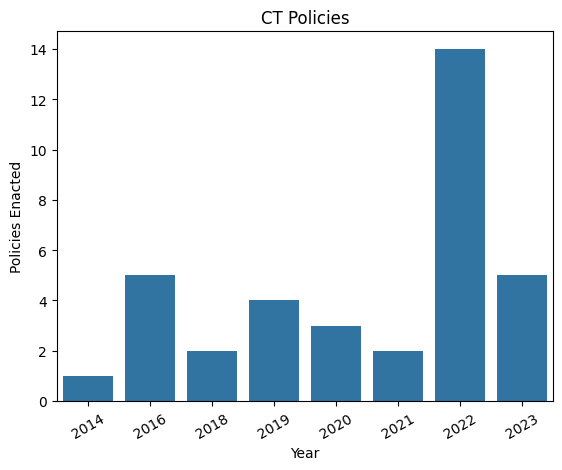

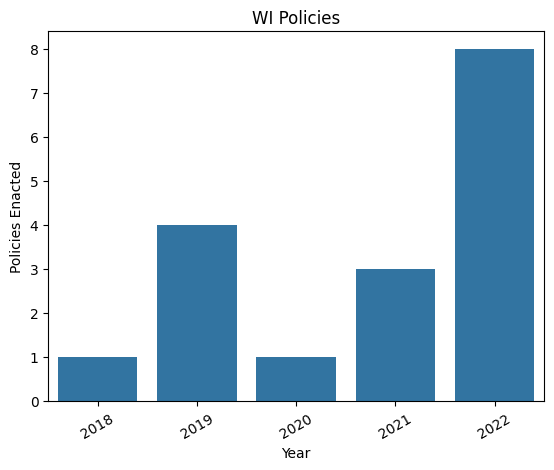

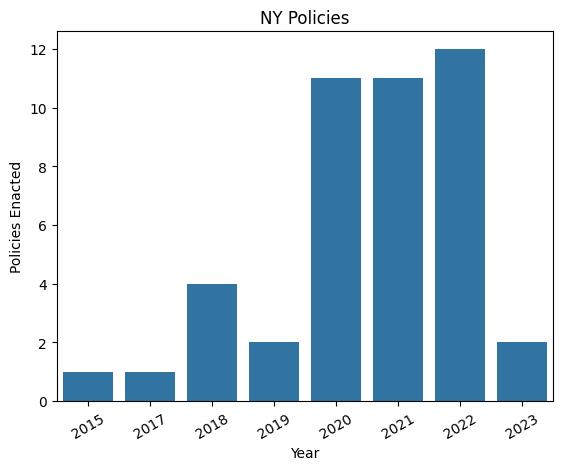

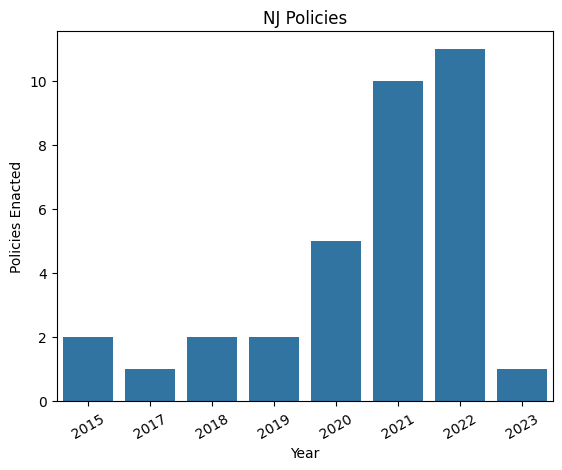

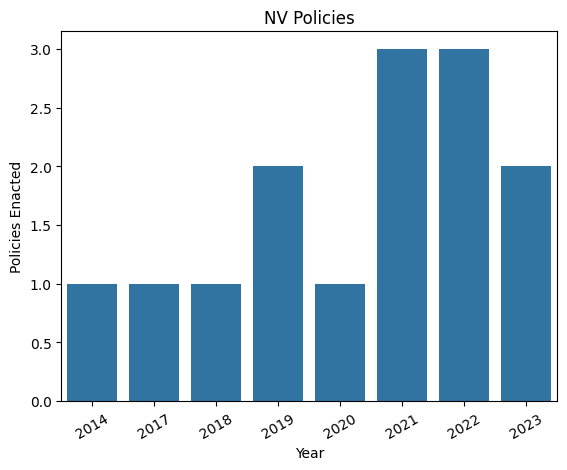

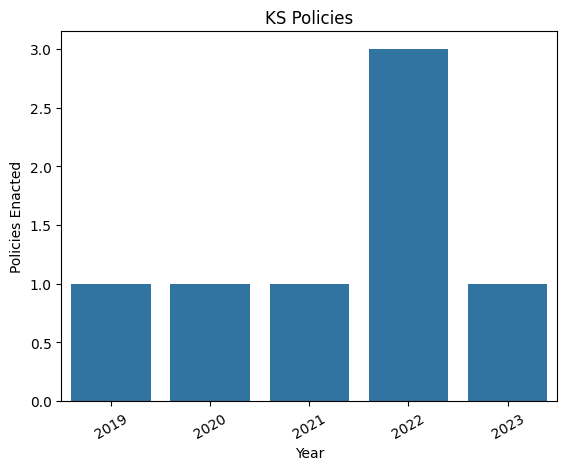

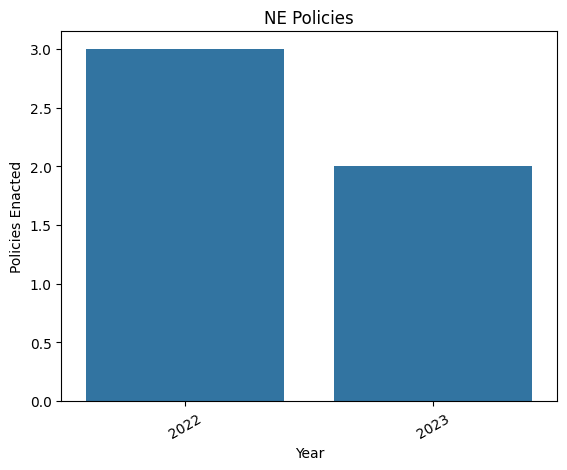

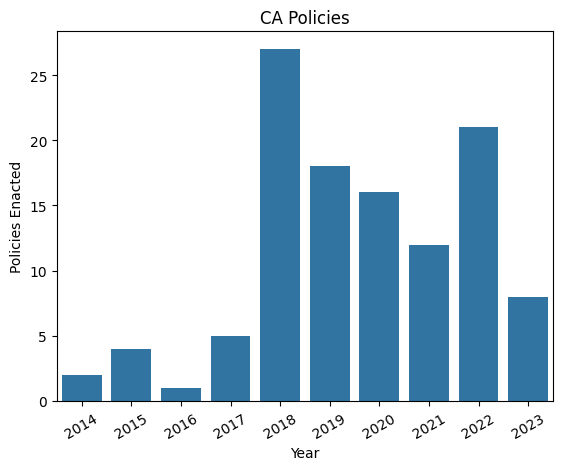

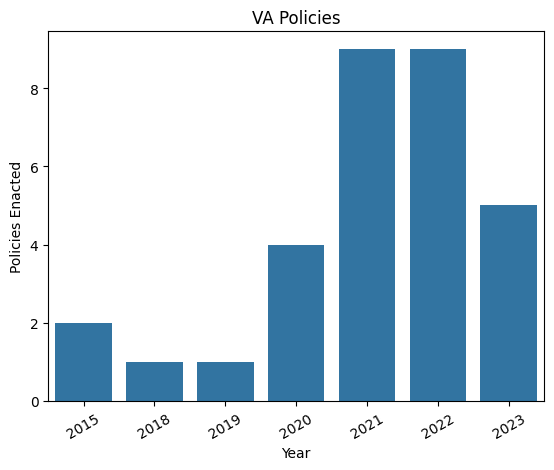

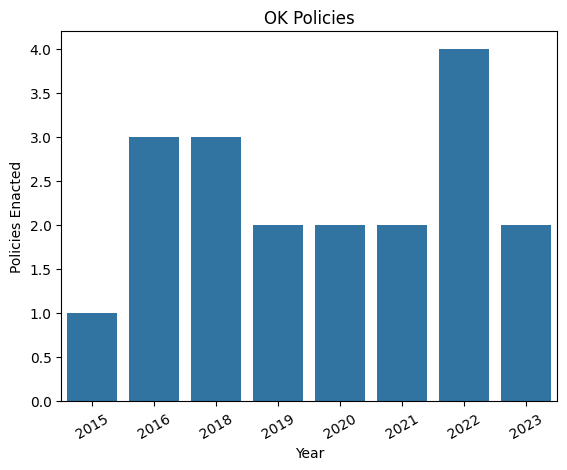

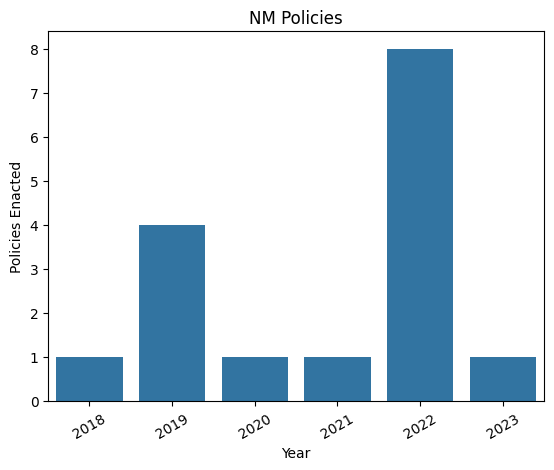

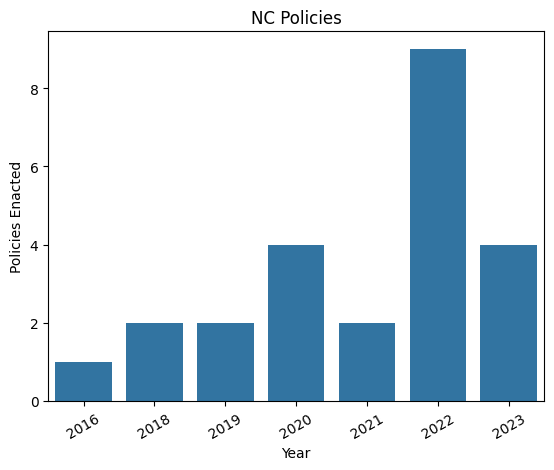

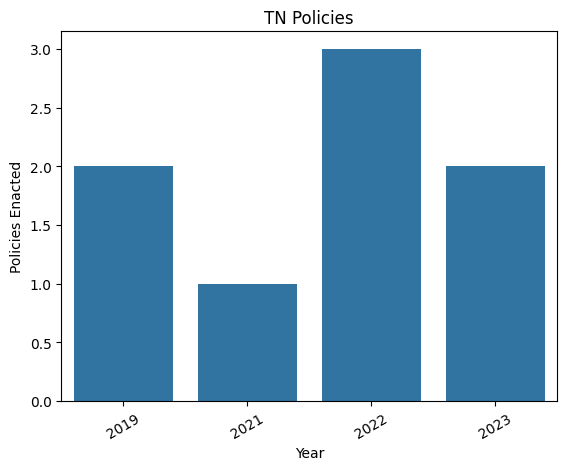

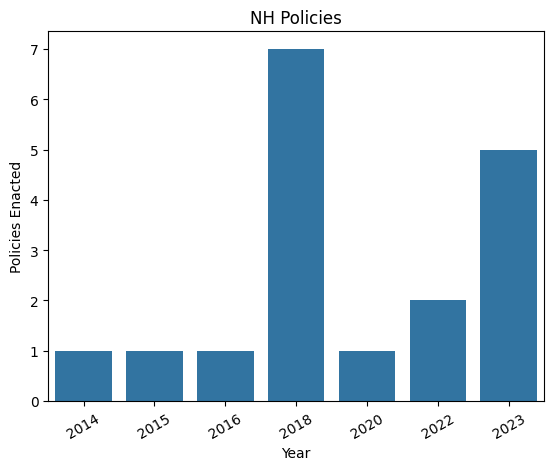

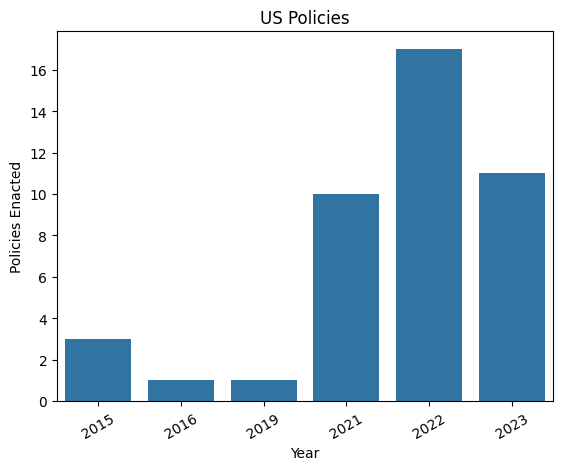

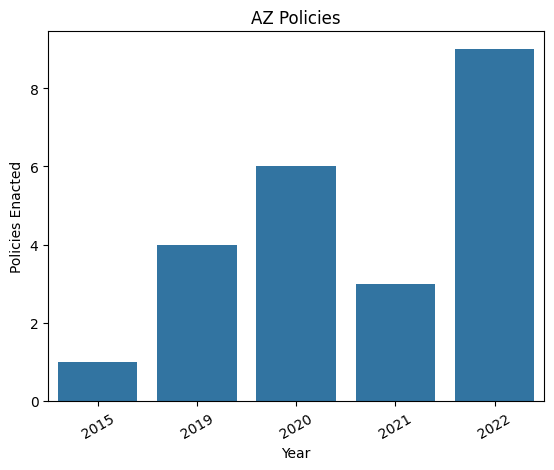

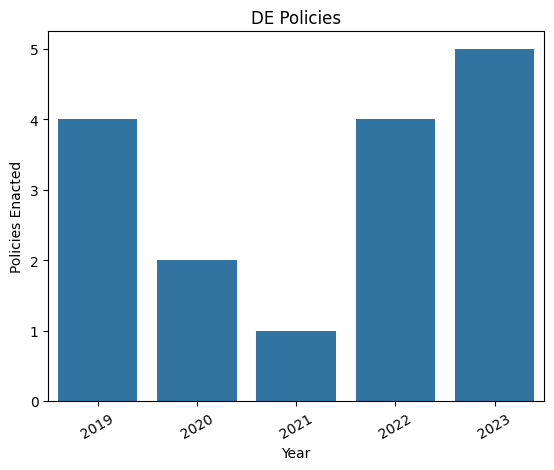

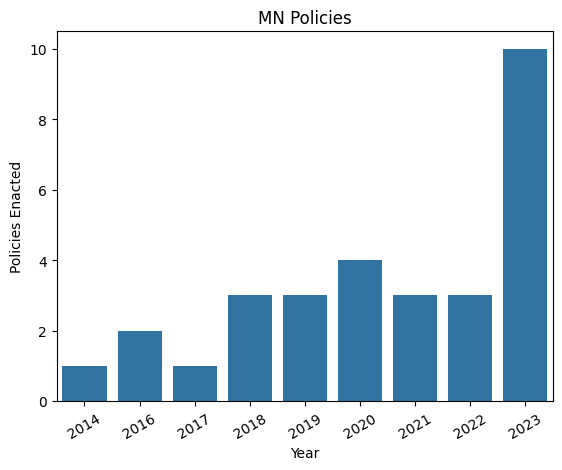

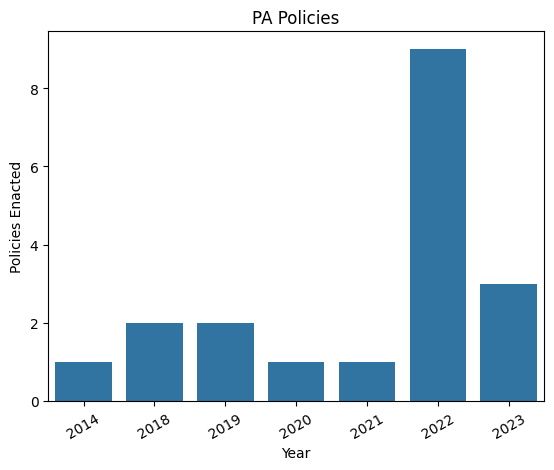

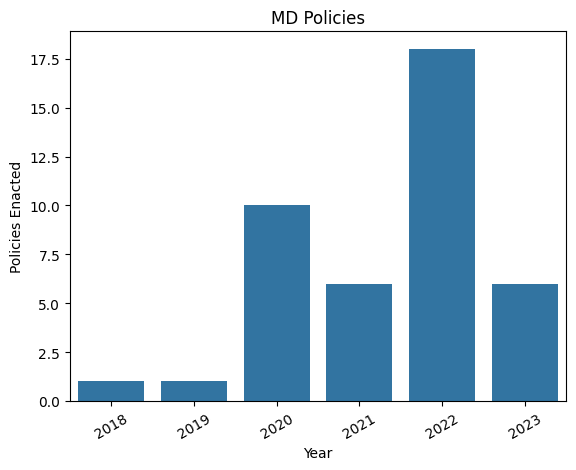

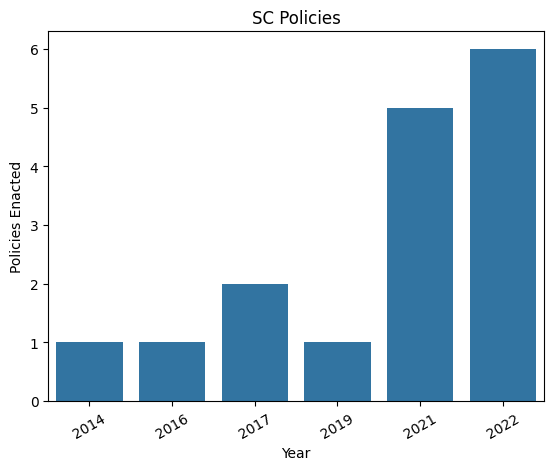

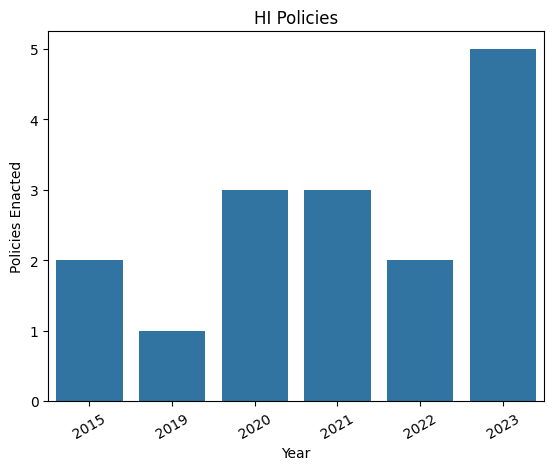

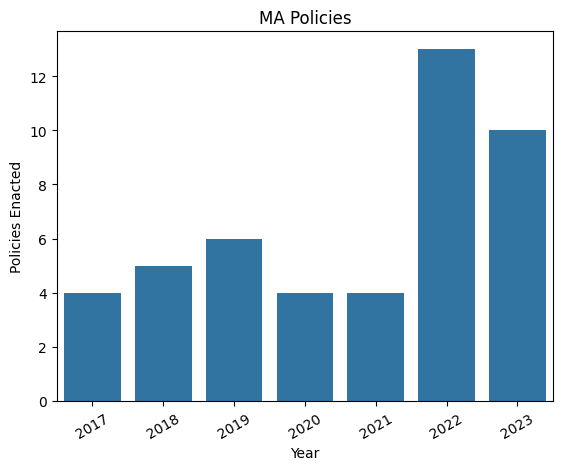

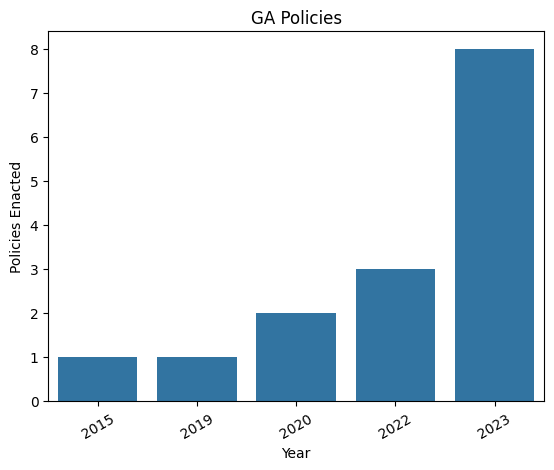

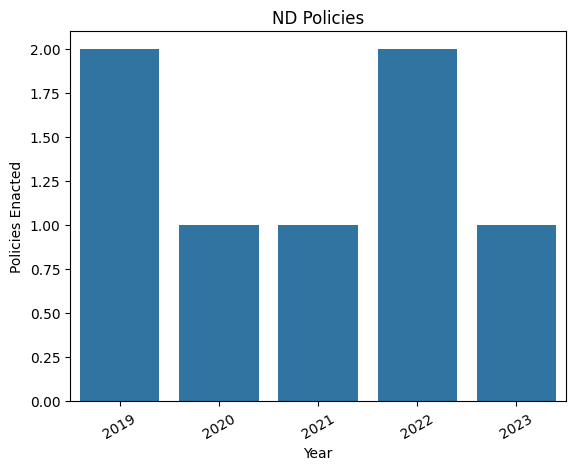

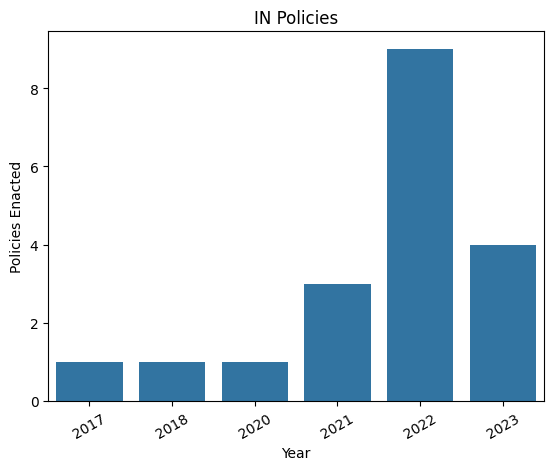

In [ ]:
# policies enacted per year by state

policies_per_year_by_state = {}
for state in set(policy_data['state']):
	state_data = filter_by_state(
		policy_data,
		state
	)
	state_data = group_by_date(state_data, parsed_date_col)
	make_barplot(
		state_data,
		parsed_date_col,
		'id',
		'Year',
		'Policies Enacted',
		f'{state} Policies'
	)
	policies_per_year_by_state[state] = state_data